root node: odor
      > -- p -- 0 % probability of being edible
      > -- y -- 0 % probability of being edible
      > -- m -- 0 % probability of being edible
      > -- n -- spore-print-colour
           > -- k -- 100 % probability of being edible
           > -- o -- 100 % probability of being edible
           > -- y -- 100 % probability of being edible
           > -- w -- habitat
                > -- p -- 100 % probability of being edible
                > -- g -- 100 % probability of being edible
                > -- d -- gill-size
                     > -- b -- 100 % probability of being edible
                     > -- n -- 0 % probability of being edible
                > -- w -- 100 % probability of being edible
                > -- l -- cap-colour
                     > -- y -- 0 % probability of being edible
                     > -- w -- 0 % probability of being edible
                     > -- n -- 100 % probability of being edible
                     > -- c -- 100 % pr

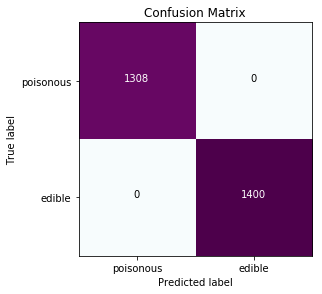

Accuracy =  100.0 %


In [127]:
import csv
import random
import numpy as np
import math
import copy
from sklearn.metrics import confusion_matrix
import matplotlib.pylab as plt
import itertools
#import warnings
#warnings.simplefilter('error', RuntimeWarning)

with open("agaricus-lepiota.data", 'r') as file:
    data = list(csv.reader(file))
    
with open("feature-names.txt", 'r') as file:
    f_names = list(csv.reader(file))
    
f_names = f_names[0]

trainingData = random.sample(data, int(len(data)*2/3))
testingData = []
for line in data:
    if line not in trainingData:
        testingData.append(line)

new_tree = create_tree(trainingData, f_names)
new_tree.draw_tree(0)
get_accuracy(new_tree, testingData, f_names)

In [8]:
class tree:
    def __init__(self, branch_name, node_name):
        self.branch = branch_name
        self.node = node_name
        self.children = []
        
    def add_child(self, child_branch):
        self.children.append(child_branch)
        
    def draw_tree(self, level):
        if level == 0:
            print("root node:", self.node)
        else:
            print(level*"     ", "> --", self.branch, "--", self.node)
        if self.children != []:
            level = level + 1
            for child in self.children:
                child.draw_tree(level)

In [9]:
#calculates entropy given one probability
def get_entropy(probability):
    
# get 2nd probability from the first
# we know there are only two probabilities because there are 2 classes
    p1 = probability
    p2 = 1 - p1
    if p1 == 0 or p2 == 0:  #math.log will complain if we give it zero
        entropy = 0         #convention of entropy calculation
    else:
        entropy = -( p1*math.log(p1, 2) + p2*math.log(p2, 2) )    #entropy formula
    return entropy

In [10]:
# calculate gain of a given feature for a given distribution
# feature_values is an array of all the values the feature can take on
def calculate_gain(distribution, entropy_of_dist, feature, feature_values):
    feature_value_counts = np.zeros((3, len(feature_values)), int)

# make feature_value_counts, which is a numpy matrix with num cols = num feature values, num rows = 2
# first row is how many of each feature value is in the distribution, eg feature 2="a" in 10 mushrooms
# second row is how many edible mushrooms there are when feature=faeture_value[i]
# third row is how many poisonous mushrooms there are when feature=faeture_value[i]
# all for calculating the entropy for each value of the feature
# this is weird sorry
    for mushroom in distribution:
        i = 0
        for f in range(0, len(feature_values)):
            if mushroom[feature] == feature_values[f]:
                feature_value_counts[0, f] = feature_value_counts[0, f] + 1
                i = f
        if mushroom[0] == "e":
            feature_value_counts[1, i] = feature_value_counts[1, i] + 1
        else:
            feature_value_counts[2, i] = feature_value_counts[2, i] + 1
       
        
# get gain of the feature using formula
# gets entropy for each feature value using feature_value_counts
    gain = entropy_of_dist
    for y in range(0, len(feature_values)):
        if sum(feature_value_counts[1:,y]) == 0:
            entropy_of_feature = 0
        else:
            entropy_of_feature = get_entropy(feature_value_counts[1, y]/sum(feature_value_counts[1:,y]))
        gain = gain - 1/len(distribution) * (feature_value_counts[0, y]) * entropy_of_feature
    
    return gain

In [11]:
# finds the feature with the highest gain given a distribution(dataset)
# feature_values is a matrix where row i contains the feature values for feature i+1
# its i+1 not i because the first element in every row of the dataset is "p" or "e", the class label
def get_next_feature(distribution, entropy, num_features, feature_values):
    #edible_count = 0
    #for mushroom in distribution:
        #if mushroom[0] == "e":
            #edible_count = edible_count + 1
            
    #entropy = get_entropy(edible_count/len(distribution))
        
    best_gain = 0
    best_feature = 0
    for feature in range(1, num_features+1):
        new_gain = calculate_gain(distribution, entropy, feature, feature_values[feature-1])
        if  new_gain > best_gain:
            best_gain = new_gain
            best_feature = feature
            
    return best_feature

In [128]:
# split the distribution based on the feature chosen in get_next_feature
# feature_values is a list of the values the feature can take on
# returns as many new distributions as there are feature values
# removes the feature we split on from the distribution, since we dont need to check it anymore
def split_dist(distro, feature, feature_values):
    distribution = copy.deepcopy(distro)
    new_distributions = []
    for i in feature_values:
        new_distributions.append([i])

    for mushroom in distribution:
        f = 0
        for y in range(0, len(feature_values)):
            if mushroom[feature] == feature_values[y]:
                f = y
        
        mushroom.pop(feature)
        new_distributions[f].append(mushroom)
        
    new_distributions = [x for x in new_distributions if len(x)!= 1]
    
    return new_distributions

In [133]:
# creates a branch of the tree and then calls itself recursively until either entropy is zero or the number of features
# to check has run out
def create_branch(root, distribution, feature_values, feature_names, num_features):
    use_feature_values = copy.deepcopy(feature_values)
    use_feature_names = copy.deepcopy(feature_names)
            
    if len(distribution) == 0:
        return
    else:
        edible_count = 0
        for mushroom in distribution:
            if mushroom[0] == "e":
                edible_count = edible_count + 1
                
        probability = edible_count/len(distribution)
        entropy = get_entropy(probability)

    
    if entropy == 0 or num_features == 0:
        probability = int(probability*100)
        root.node = str(probability) + " % probability of being edible"
    else:
        next_feature = get_next_feature(distribution, entropy, num_features, use_feature_values)
        next_branches = split_dist(distribution, next_feature, use_feature_values[next_feature-1])
        next_feature_name = use_feature_names[next_feature-1]
    
        use_feature_values.pop(next_feature-1)
        use_feature_names.pop(next_feature-1)
        
        root.node = next_feature_name
    
        for branch in next_branches:
            tree_branch = tree(branch[0], "node_name")
            root.add_child(tree_branch)
            create_branch(tree_branch, branch[1:], use_feature_values, use_feature_names, num_features - 1)

In [71]:
# theoretically done but unable to test until create_branch is done
def create_tree(distribution, feature_names):
    
    num_features = len(feature_names)
    feature_values = []
    for f in range(num_features):
        l = []
        for m in distribution:
            l.append(m[f+1])
        
        feature_values.append(list(set(l)))
        
    root = tree("root", "first feature")
    create_branch(root, distribution, feature_values, feature_names, num_features)
    return root

In [129]:
def test_tree(tree_root, test_data, feature_names, predicted, truth):
      
#if at end of a branch
    if tree_root.children == []:
        for t in test_data:
            if int(tree_root.node.split(" ")[0]) > 50:
                predicted.append(1)
            else:
                predicted.append(-1)
            
            if t[0] == "e":
                truth.append(1)
            else:
                truth.append(-1)
    else:    
        use_feature_names = copy.deepcopy(feature_names)
        feature = tree_root.node
        feature_index = use_feature_names.index(feature) + 1
    
        feature_values_test = []
        for child in tree_root.children:
            feature_values_test.append(child.branch)
    
        split_tests = split_dist(test_data, feature_index, feature_values_test)
        use_feature_names.pop(feature_index - 1)
    
        for tests in split_tests:
            for child in tree_root.children:
                if child.branch == tests[0]:
                    test_tree(child, tests[1:], use_feature_names, predicted, truth)
    

In [126]:
def get_accuracy(tree_root, test_data, feature_names):
    predicted_classes = []
    true_classes = []
    
    test_tree(tree_root, test_data, feature_names, predicted_classes, true_classes)
    
    cm = confusion_matrix(true_classes, predicted_classes)

#plot confusion matrix
    title = "Confusion Matrix"
    classes = ['poisonous','edible']
    cmap=plt.cm.BuPu
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    if cm.max() > 1:
        thresh = cm.max()/2
    else:
        thresh = 1
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
#find accuracy
    accuracy = (cm[0][0] + cm[1][1])/(len(test_data))*100
    print("Accuracy = ", accuracy, "%")

In [132]:
# testing using the last question in the decision trees tut
# data for this is in coms3.txt
with open("coms3.txt", 'r') as file:
    test = list(csv.reader(file))
    

for line in test:
    print(line)

tr = create_tree(test, ["coms2 mark", "doing labs?", "doing tuts?"])
tr.draw_tree(0)
pred = []
tru = []
testy = [['e', 'B', 'yes', 'yes'],['e', 'C', 'yes', 'no'], ['e', 'A', 'no', 'yes']]


['e', 'A', 'no', 'yes']
['p', 'C', 'yes', 'no']
['e', 'C', 'no', 'yes']
['e', 'B', 'yes', 'yes']
['p', 'B', 'no', 'no']
['e', 'C', 'yes', 'no']
['p', 'A', 'no', 'no']
['e', 'B', 'yes', 'no']
root node: doing tuts?
      > -- no -- doing labs?
           > -- no -- 0 % probability of being edible
           > -- yes -- coms2 mark
                > -- C -- 50 % probability of being edible
                > -- B -- 100 % probability of being edible
      > -- yes -- 100 % probability of being edible


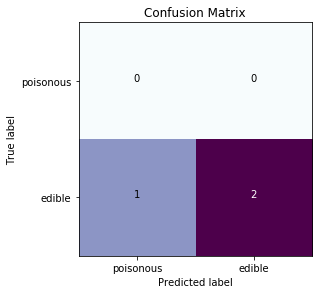

Accuracy =  66.66666666666666 %


In [131]:
get_accuracy(tr, testy, ["coms2 mark", "doing labs?", "doing tuts?"])